In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [57]:
## Load csv to DataFrame
data = pd.read_csv(r".\btcusd_data.csv")

## Convert epoch time to datetime format
data["timestamp"] = pd.to_datetime(data["timestamp"], unit='s')

## Include only required columns in DataFrame and rename"timestamp" column
data = data [["close", "high", "low", "open", "timestamp", "volume"]]
data = data.rename(columns = {"timestamp": "time"})

#set "time: column as index
data.set_index(["time"], inplace = True)

#Selecting column which would be used in claculations (dropping open, high, low, volume)
data = data.iloc[: , 0:1]

In [58]:
## Creating Simple Moving Averages for Close price
## The number of SMAs can be adjusted through list_comprehension in sma_list variable
sma_list = [x for x in range(10, 740, 10)]
for sma in sma_list:
    data[f"sma_{sma}"] = np.nan
    data[f"sma_{sma}"] = data.loc[:, "close"].rolling(window=sma).mean()

## Drop rows with NaNs which appeared from creating SMAs
data = data.dropna()

## Creating columns and filling them with percent value of difference between "CLOSE" and "MOVING AVERAGES"
for movings in data:
    if movings.startswith("sma"):
        column_name = f'price_diff_from_{movings}'
        moving_num = int(movings.split("_")[1])
        data[column_name] = (data["close"] - data[movings]) / data[movings] * moving_num
    else:
        pass
    
## Scale data with StandardScaler()
scaler = StandardScaler()
data.iloc[:,-1:-74:-1]=scaler.fit_transform(data.iloc[:,-1:-74:-1].to_numpy())

In [68]:
## Function to define bounds of min and max values in customized range of time (8, 15, 30 days)
## which is set through bounds in iloc[-1:range_of_time_backwards:-1]

period_to_compare = int(input("Period from today backwards to compare with historical data: ")) * -1

def current_like_state(x: pd.DataFrame, y) -> range :
    last_values = x[y].iloc[-1:period_to_compare:-1]
    lower_bound = min(last_values)
    upper_bound = max(last_values)
    return lower_bound, upper_bound

## Create dict with lower and upper bound of price diff in selected range

bounds_dict = {}
for price_diff_col in data:
    if price_diff_col.startswith("price_diff"):
        lower_bound, upper_bound = current_like_state( x = data, y = price_diff_col)
        bounds_dict[f'{price_diff_col}'] = {}
        bounds_dict[f'{price_diff_col}'][f'lower'] = lower_bound
        bounds_dict[f'{price_diff_col}'][f'upper'] = upper_bound
    else:
        pass
    
## Function to compare values extraced by "current_like_state" with historical data

def compare_values(x, lower_bound, upper_bound):
    if lower_bound <= x <= upper_bound:
        return x
    else:
        np.nan
        

## Applying "compare_values" function and getting values which represent if the price had been in this range before 
## for each of moving average. If "True" value is placed to the created columns

for k in bounds_dict.keys():
    data[f'range_{k}'] = np.nan
    data[f'range_{k}'] = data[k].apply(compare_values, args = (bounds_dict[k]["lower"], bounds_dict[k]["upper"]))
    
## Creating column which represent intersection of values of moving avergaes 

data['intersection'] = np.nan

columns_to_intersect_list = []

for col in data.columns:
    if col.startswith("range"):
        columns_to_intersect_list.append(col)        

level_of_intersection = float(input("Level of intersection of SMAs in %: "))

def intersecting_columns(row: pd.Series, level_of_intersection=level_of_intersection) -> int:
    nans_columns = row[columns_to_intersect_list].notna()
    count_nans = nans_columns.sum()
    
    if count_nans > (len(columns_to_intersect_list) * (level_of_intersection / 100)):
        return 1
    return np.nan

    
data["intersection"] = data.apply(intersecting_columns, axis=1)

if data['intersection'].notna().sum() > period_to_compare:
    print(f"Number of intersected values in df not including compared period: " 
          f"{(data['intersection'].notna().sum() + period_to_compare)}")
else:
    print("No intersections in historical data")


Period from today backwards to compare with historical data:  40
Level of intersection of SMAs in %:  60


Number of intersected values in df not including compared period: 42


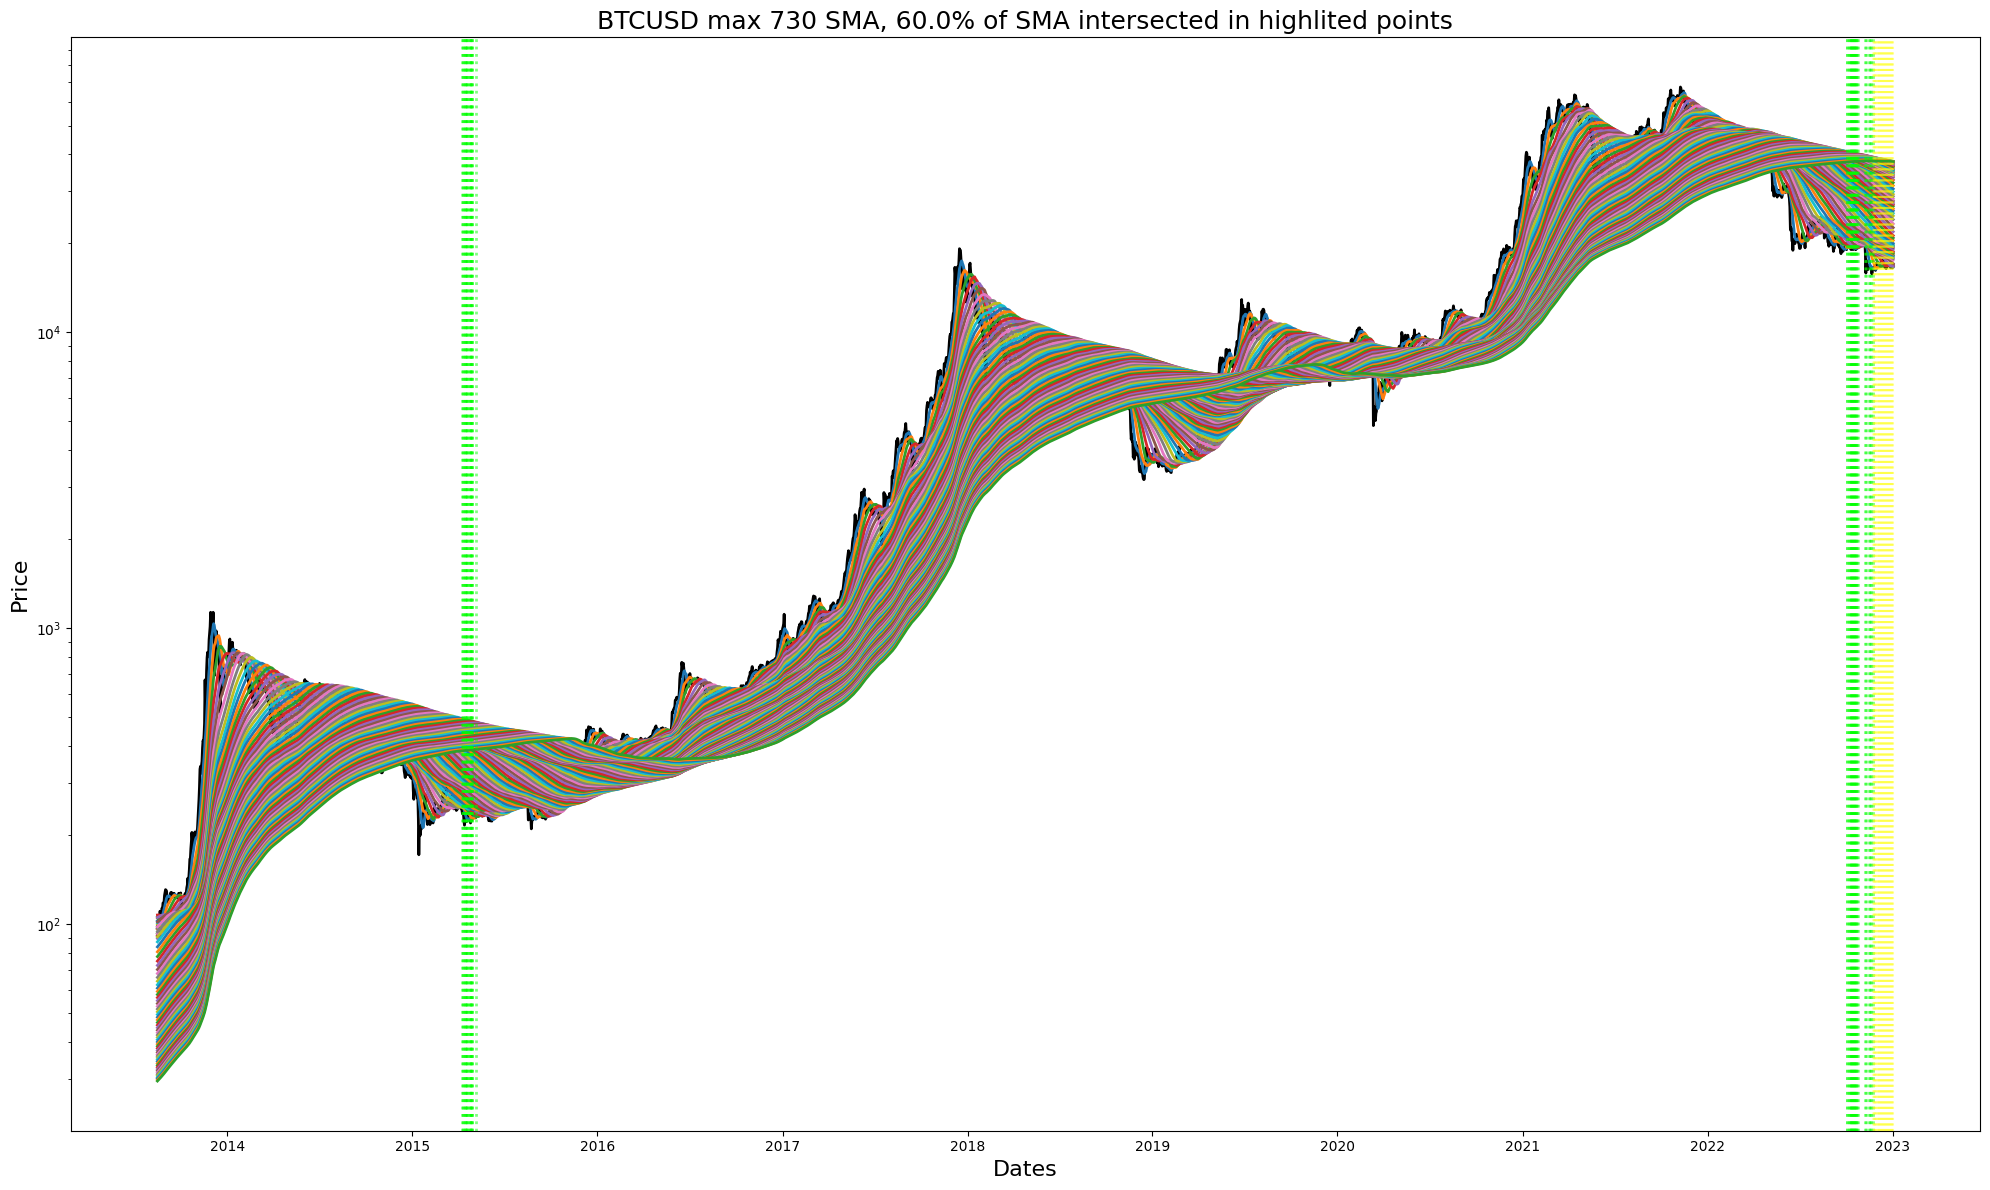

In [69]:
## Plot periods which correspond to intersection of multiple values, mening that "current state" is similar to previous one, 
## which you can see on chart 

fig, ax = plt.subplots(figsize =(20, 12))
temp = data
comparing_history_len = len(temp) + period_to_compare
temp_historical = temp.iloc[:comparing_history_len, :]
temp_current = temp.iloc[comparing_history_len:, :]

start_color_y = 0
end_color_y = temp.close.max()
non_empty_historical = temp_historical.loc[~temp_historical["intersection"].isna()]
non_empty_current = temp_current.loc[~temp_current["intersection"].isna()]
x_shape = non_empty_historical.shape[0]
start_color_y = [0] * x_shape
end_color_y = [end_color_y] * x_shape

ax.plot(temp.index, temp.close, linewidth=2, color = "black")

columns_to_plot = []
for col in temp.columns:
    if col.startswith("sma"):
        columns_to_plot.append(col)        

for cols in columns_to_plot:
    ax.plot(temp.index, temp[f"{cols}"], linewidth=2, linestyle = "solid", alpha = 1)


for index in non_empty_historical.index:
    plt.axvline(x=index, color='lime',linewidth=2, linestyle='dotted', alpha = 0.5)

for index in non_empty_current.index:
    plt.axvline(x=index, color='yellow', linestyle='dotted', alpha = 0.25)
    

plt.title(f"BTCUSD max {max(sma_list)} SMA, {round(level_of_intersection, 0)}% "
          f"of SMA intersected in highlited points", fontsize = 18)
plt.xlabel('Dates', fontsize = 16)
plt.yscale('log')
plt.ylabel('Price', fontsize = 16)
plt.tight_layout()

plt.show()